<a href="https://colab.research.google.com/github/AviFeygin/EECS-4080/blob/main/Israpol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import torch
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import keras as ker
import seaborn as sea
import xlrd as xlr
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import statsmodels.api as stm

#ignore all warnings
import warnings
warnings.filterwarnings('ignore')
sea.set()

import itertools
!pip install --upgrade xlrd

from google.colab import data_table
data_table.enable_dataframe_formatter()
from vega_datasets import data


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading Text

In [2]:
data = '/content/drive/MyDrive/Polls.xls'
polls = pd.read_excel(data)
polls_2021 = pd.read_excel(data, sheet_name=0, index_col=0)

In [3]:
print("polls_2021 shape:")
print(polls_2021.shape)
just_polls = polls_2021.iloc[1:161, 5:25]
print("just polls")
display(just_polls)
display(just_polls['Likud'])


polls_2021 shape:
(159, 23)
just polls


,Likud,Yesh Atid,Blue & White,Joint List,Shas,UTJ,Yisrael Beiteinu,Meretz,Ra'am,Yamina,New Hope,Labor,Religious Zionist,NEP,Right Wing,Left Wing,religious,Arab
Date,,,,,,,,,,,,,,,,,,
2021-03-20 00:00:02,31,19,4.0,8,8,7,7,4.0,4.0,9,9,5.00,5.00,1.68,61.00,28.00,15,16.0
2021-03-19 00:00:03,30,18,4.0,8,8,7,6,4.0,4.0,10,10,6.00,5.00,0.00,61.00,28.00,15,16.0
2021-03-19 00:00:04,32,18,4.0,8,8,7,7,4.0,4.0,9,9,6.00,4.00,1.56,61.00,28.00,15,16.0
2021-03-19 00:00:05,31,19,4.0,8,8,7,7,4.0,4.0,9,9,5.00,5.00,1.68,61.00,28.00,15,16.0
2021-03-18 00:00:06,30,19,5.0,8,8,6,8,4.0,4.0,10,8,5.00,5.00,0.00,61.00,29.00,14,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-17 00:02:35,41,15,11.0,16,10,7,8,5.0,0.0,7,0,1.32,0.60,0.00,56.60,27.32,17,21.0
2020-06-17 00:02:36,41,15,10.0,16,9,7,8,6.0,0.0,8,0,2.76,1.68,0.00,58.68,27.76,16,22.0
2020-06-11 00:02:37,41,16,13.0,15,9,8,7,5.0,0.0,6,0,0.00,0.00,0.00,54.00,29.00,17,20.0


Date
2021-03-20 00:00:02    31
2021-03-19 00:00:03    30
2021-03-19 00:00:04    32
2021-03-19 00:00:05    31
2021-03-18 00:00:06    30
                       ..
2020-06-17 00:02:35    41
2020-06-17 00:02:36    41
2020-06-11 00:02:37    41
2020-06-08 00:02:38    40
2020-05-26 00:02:39    41
Name: Likud, Length: 158, dtype: int64

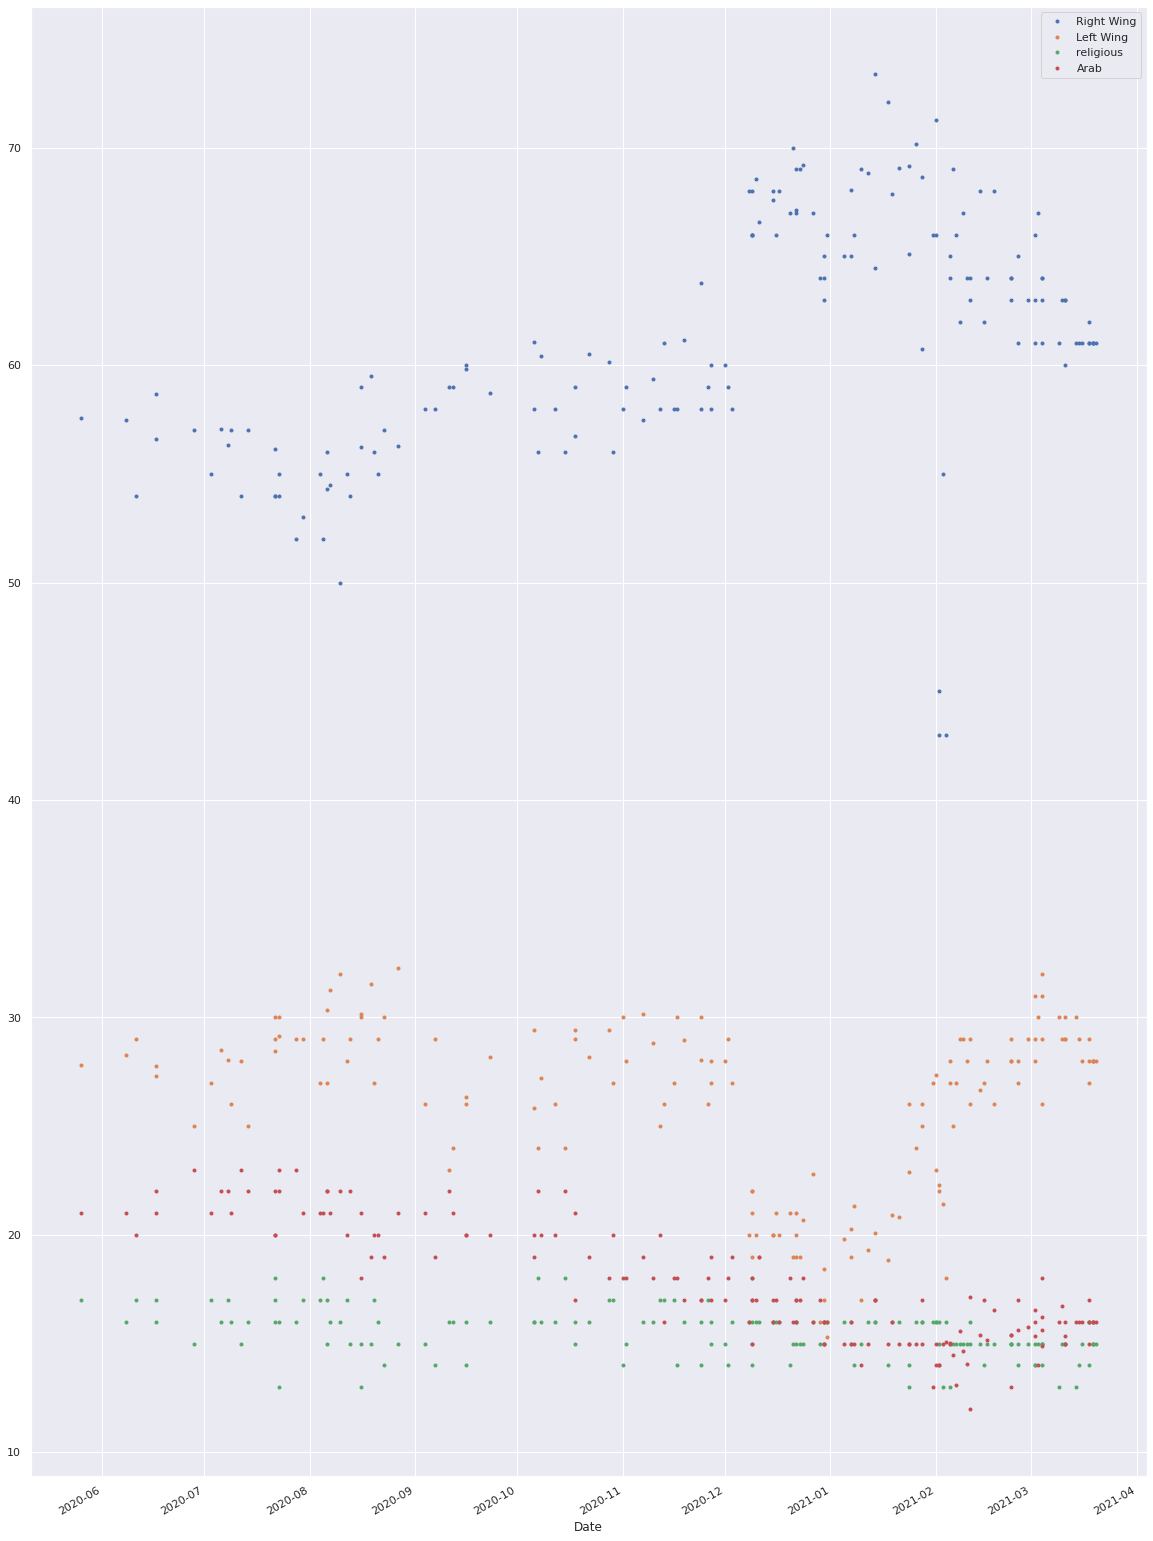

In [43]:
#[:,-1] rows and columns
fig, ax = plt.subplots()


just_polls_parties = just_polls.iloc[:, 0:13]
just_polls_blocks = just_polls.iloc[:,14:18]
just_polls_blocks.plot(figsize=(20, 30, ), style =".")

fig, ax = plt.subplots(figsize=(8,5))
df = pd.DataFrame({"x": x, "y":y})
#You pass the wanted axis to the ax argument
df.plot(kind='scatter', x='x', y='y',title="Nice title", grid=True,fontsize=10, ax=ax) 
ax.plot(line, x_line, zorder=-1)

covariance


,Likud,Yesh Atid,Blue & White,Joint List,Shas,UTJ,Yisrael Beiteinu,Meretz,Ra'am,Yamina,New Hope,Labor,Religious Zionist,NEP,Right Wing,Left Wing,religious,Arab
Likud,1.000000,-0.012908,0.418199,0.446583,0.290848,0.055277,0.222274,0.135187,-0.144732,-0.343414,-0.435688,-0.106310,-0.119042,-0.150649,-0.353764,0.240186,0.249390,0.427944
Yesh Atid,-0.012908,1.000000,0.084773,-0.128206,-0.274607,-0.248405,0.243046,-0.079238,0.368973,0.110796,-0.415142,0.355524,0.233971,0.085267,-0.354907,0.804287,-0.344476,0.043159
Blue & White,0.418199,0.084773,1.000000,0.791174,0.305760,0.224668,0.421803,0.585212,-0.462412,0.511914,-0.772490,-0.541852,-0.597296,-0.628405,-0.554588,0.462455,0.354711,0.793419
Joint List,0.446583,-0.128206,0.791174,1.000000,0.470216,0.308813,0.405784,0.628900,-0.675020,0.355824,-0.658657,-0.682948,-0.689659,-0.617519,-0.554130,0.110044,0.525110,0.903789
Shas,0.290848,-0.274607,0.305760,0.470216,1.000000,0.150857,0.360816,0.063551,-0.298374,0.050943,-0.291471,-0.257239,-0.218658,-0.288067,-0.220880,-0.072185,0.835683,0.340584
UTJ,0.055277,-0.248405,0.224668,0.308813,0.150857,1.000000,-0.062751,0.199295,-0.355251,0.096210,-0.033883,-0.317693,-0.359159,-0.179495,-0.082495,-0.154982,0.668995,0.199994
Yisrael Beiteinu,0.222274,0.243046,0.421803,0.405784,0.360816,-0.062751,1.000000,0.200680,-0.167452,0.247420,-0.548913,-0.212517,-0.169498,-0.301996,-0.316914,0.314066,0.236425,0.405864
Meretz,0.135187,-0.079238,0.585212,0.628900,0.063551,0.199295,0.200680,1.000000,-0.627434,0.478517,-0.417306,-0.668419,-0.613369,-0.520121,-0.292226,-0.008504,0.158505,0.710516
Ra'am,-0.144732,0.368973,-0.462412,-0.675020,-0.298374,-0.355251,-0.167452,-0.627434,1.000000,-0.415227,0.257197,0.801594,0.687739,0.478178,0.152638,0.334735,-0.422555,-0.391715
Yamina,-0.343414,0.110796,0.511914,0.355824,0.050943,0.096210,0.247420,0.478517,-0.415227,1.000000,-0.416493,-0.470669,-0.493226,-0.438859,-0.051857,0.156121,0.091753,0.331811


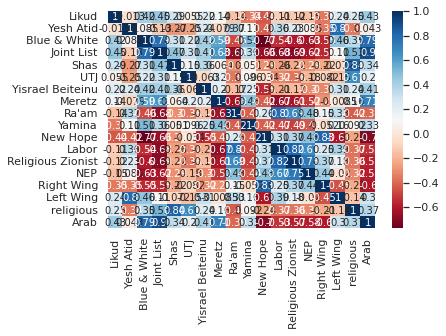

In [17]:
covariance = just_polls.corr()
print("covariance")
display(covariance)
heat_map = sea.heatmap(covariance,annot=True, cmap = "RdBu")
plt.show()

In [18]:
correlation_3_day = pd.read_excel(data, sheet_name=1, index_col=0)
display(correlation_3_day)

,Polling firm,Publisher,Poll Size,Margin of Error,Days Before election,Likud,Yesh Atid,Blue & White,Joint List,Shas,...,difference Ra'am,difference Yamina,difference New Hope,difference Labor,difference Religious Zionist,difference NEP,difference Right Wing,difference Left Wing,difference religious,difference Arab
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-23 00:00:00,Election results[5],NaN,NaN,0,0,30,17,8,6,9,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0
2021-03-20 00:00:00,Smith,Mako[12],900,3.1,3,31,19,4,8,8,...,0.222222,-0.222222,0.111111,-0.111111,0.111111,0.44,-0.111111,0.0,-0.111111,0.0
2021-03-19 00:00:00,Camil Fuchs,Channel 13[7],1103,3.4,4,30,18,4,8,8,...,0.222222,0.444444,0.777778,0.555556,0.444444,-1.24,-0.111111,0.0,-0.111111,0.0
2021-03-19 00:00:00,Midgam/iPanel,Channel 12[8],1000,3.1,4,32,18,4,8,8,...,0.222222,-0.555556,-0.222222,0.555556,-0.555556,0.32,-0.111111,0.0,-0.111111,0.0
2021-03-19 00:00:00,Kantar,Kan 11[11],1406,2.6,4,31,19,4,8,8,...,0.222222,-0.555556,-0.222222,-0.444444,0.444444,0.44,-0.111111,0.0,-0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Direct Polls,1.017094,-0.404915,0.110897,-0.143162,0.472222,0.03312,0.629274,-0.564231,0.192265,-0.498932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maagar Mohot,0.212862,-0.610205,0.362331,0.747585,0.209843,0.169082,-0.356582,0.080809,-0.157694,-0.829408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Geocartographia,-1,-0.25,1.25,0,-0.25,0.25,-0.75,0.75,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3 day rolling average

In [19]:
correlation_3_day = correlation_3_day.iloc[1:159, 25:35]
display(correlation_3_day)


,rolling blue & White,rolling Joint List,rolling Shas,rolling UTJ,rolling Yisrael Beiteinu,rolling Meretz,rolling Ra'am,rolling Yamina,rolling New Hope,rolling Labor
Date,,,,,,,,,,
2021-03-20,4.444444,8.111111,8.222222,6.888889,7.333333,4.111111,3.777778,9.222222,8.888889,5.111111
2021-03-19,4.444444,8.111111,8.222222,6.888889,7.333333,4.111111,3.777778,9.555556,9.222222,5.444444
2021-03-19,4.444444,8.111111,8.222222,6.888889,7.333333,4.111111,3.777778,9.555556,9.222222,5.444444
2021-03-19,4.444444,8.111111,8.222222,6.888889,7.333333,4.111111,3.777778,9.555556,9.222222,5.444444
2021-03-18,4.444444,8.111111,7.888889,6.888889,7.444444,4.111111,3.777778,10.111111,9.444444,5.222222
...,...,...,...,...,...,...,...,...,...,...
2020-06-17,10.500000,16.000000,9.500000,7.000000,8.000000,5.500000,0.000000,7.500000,0.000000,2.040000
2020-06-17,10.500000,16.000000,9.500000,7.000000,8.000000,5.500000,0.000000,7.500000,0.000000,2.040000
2020-06-11,12.500000,15.000000,9.000000,7.500000,8.000000,5.500000,0.000000,7.000000,0.000000,1.140000


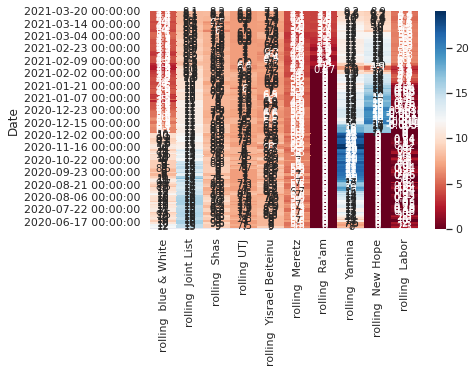

ValueError: ignored

In [20]:
correlation_3_poll = pd.read_excel(data, sheet_name=2, index_col=0)
correlation_3_poll = correlation_3_poll.iloc[444:454, 1:19]

heat_map2 = sea.heatmap(correlation_3_day, annot=True, cmap = "RdBu");
plt.show()
heat_map3 = sea.heatmap(correlation_3_poll, annot=True, cmap = "RdBu");
plt.show()
# temp = just_polls[1:1, 1:1]
# start, stop =1;
stm.nonparametric.lowess()


